In [1]:
import os
import math
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from skimage import io
from skimage.morphology import extrema
from skimage.measure import label

import skimage

import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters


import imageio

import javabridge 
import bioformats
javabridge.start_vm(class_path=bioformats.JARS, max_heap_size='8G')

#import net.imageJ.ImageJ




import sys
import time




#For the YOLO Network
import logging
import cv2
import torch
from torchvision import transforms as tf
import brambox.boxes as bbb
import lightnet as ln



#For the GUI
import tkinter as tk
from tkinter import ttk

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk

#for key bindings
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure
import matplotlib.animation as animation
from matplotlib import style




In [2]:
# See your current version of python/anaconda
print (sys.version)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]


In [26]:
class ImagingParameters():
    def __init__(self, data_path, **kwargs):
        
        self.data_path = data_path
        for key, value in kwargs.items():
            setattr(self, key, value)
            #print (key, value, getattr(self, key))
            
            
        
        #Assert that the core variables are all set correctly.
        core_variables = ['channel_array', 'channel_thresholds', 'suffix', 'machine_learning_mode']
        print (core_variables)
        self.assert_variables(core_variables, "Core")

        
      
        
        #Store the dataframes from each of the experiments
        self.directory_list = self.find_files(self.data_path, {})
        self.dataframes = []
        #print(self.directory_list)
        
        
        #List containing all of the final dataframes for convenience
        self.experiments = []
        
        
        
                 
        machine_learning_args = [""]
        if (self.machine_learning_mode == True):
            
            network_variables = ['classes', 'network_size', 'labels', 'conf_thresh', 'nms_thresh', 'use_cuda']
            self.assert_variables(network_variables, "Network")              
                 
            self.initializeROINetwork()
            
        else:
            automatic_detection_variables = ['max_neighborhood_size', 
                                             'max_threshold', 
                                             'local_max_avg_radius', 
                                             'thresh_tolerance', 'IoU_match_thresh']
            self.assert_variables(automatic_detection_variables, "Local Max Detection")
            
            
        
        subframes = 0
        for items in self.channel_array:
            subframes += items
            
        self.frames_per_timepoint = subframes
        
        
        
        #If you are using the anisotropy analysis, create the relevant correction factors:

        
        if "Anisotropy" in self.image_type_array:
            
            
            #Assert that the correct variables are defined
            ani_variables = ['numerical_aperture', 'index_of_refraction', 'magnification', 'gFactor']
            self.assert_variables(ani_variables, "Anisotropy")
            
            
            
            asin = math.asin(self.numerical_aperture/self.index_of_refraction) 
            cos = math.cos(asin)

            kA = (2.0 - 3.0 * cos + cos * cos * cos) / (6.0 * (1.0 - cos))
            kB = (1.0 - 3.0 * cos + 3.0 * cos * cos - cos * cos * cos) / (24.0 * (1.0 - cos))
            kC = (5.0 - 3.0 * cos - cos * cos - cos * cos * cos) / (8.0 * (1.0 - cos))


            self.kA = kA
            self.kB = kB
            self.kC = kC

            print (kA, kB, kC)
            
            
            
            
            
            
            
            
            
    def assert_variables(self, variables, identifier = ""):
            for attribute in variables:
                assert hasattr(self, attribute), f"Error: {identifier} attribute {attribute} was not set.  Check your config file"


    def find_files(self, path, directory_list = {}):
        all_files = os.listdir(path)
        #print (all_files)
        for files in all_files:
            #print (path, os.path.dirname(path))

            #When you find the appropriate file, add the directory to the dictionary for processing
            if os.path.isfile(f'{path}{os.sep}{files}'):
                #print ("Found a file")
                if files.endswith(self.suffix):
                    #print (f"Ends with ome.tif ({files})")
                    prev_directory = os.path.dirname(path)
                    current_directory = path.replace(prev_directory, "")
                    if prev_directory in directory_list:
                        directory_list[prev_directory][current_directory] = None

                    else:
                        directory_list[prev_directory] = {current_directory : None}



            elif os.path.isdir(f'{path}{os.sep}{files}'):
                directory_list = self.find_files(f'{path}{os.sep}{files}', directory_list)
                #print ("Found a directory")


        return (directory_list)
    
    
    
    
        
        


    def iterate_through_files(self):
        """
        The purpose of this function is to iterate through all of the files in the directory list and then
        send them to the relevant analysis program
        """ 
        
        dataframes = self.dataframes
        suffix = self.suffix
        directory_list = self.directory_list
        debug_mode = self.debug_mode
        machine_learning_mode = self.machine_learning_mode


        if debug_mode == True:
            #Start a new dataframe each time
            dataframes = []



        #knowing the previous directory we looked at helps to determine whether we should append the
            #results to a current dataframe or not.  You want to append if the data are from the same cells
        prev_directory = ""
        new_dataframe = True


        for root_dir in directory_list:
            #note: there will usually only be one subdirectory per root_dir
            for directories in directory_list[root_dir]:
                print (os.path.dirname(os.path.dirname(directories)))
                if os.path.dirname(os.path.dirname(prev_directory)) == os.path.dirname(os.path.dirname(directories)):
                    print ("From the same core directory")
                    new_dataframe = False
                else:
                    print ("Not from the same core directory")
                    #if they do not share the same root directory, you need to create a new dataframe
                    new_dataframe = True
                    dataframes.append({})


                file_list = os.listdir(f'{root_dir}{directories}')


                for files in file_list:
                    if files.endswith(suffix):

                        #store all the relevant information about the image in a new class                    
                        current_Image = ImageClass(f'{root_dir}{directories}',
                                                  files, Parameters.channel_array,
                                                  Parameters.image_type_array, Parameters.channel_thresholds)

                        #Analyze the image
                        
                        dataframes = image_Analysis(current_Image=current_Image, 
                                                         Parameters = Parameters, 
                                                         dataframes = dataframes)



                prev_directory = directories


        #consolidate the dataframes
        dataframes = self.consolidate_dataframes(dataframes)

        self.dataframes = dataframes
        return (dataframes)

            
            
    def consolidate_dataframes(self, dataframes):

        """
        Combine the dataframes from each image into one consolidated dataframe
        
        """
        
        
        #dataframes = self.dataframes
       
        for index, _  in enumerate(dataframes):   
            final_dataframe = pd.DataFrame([])
            for filenames in dataframes[index]:
                #print (f"current filename is: {filenames}")
                df_interest = dataframes[index][filenames]
                #print (type(df_interest))
                #print (df_interest)
                if len(final_dataframe)==0:
                    #print ("need a new dataframe")
                    final_dataframe = df_interest
                else:
                    #print ("Appending")
                    final_dataframe = final_dataframe.append(df_interest, ignore_index = True, sort = False)


            dataframes[index] = {"Total": final_dataframe}
            self.experiments = self.experiments.append(final_dataframe)
            #print (final_dataframe)


        self.dataframes = dataframes
        

        return (dataframes)
    
    
    
    def initializeROINetwork(self):
        #These will eventually be in a configuration file
        self.log = logging.getLogger('lightnet.detect')
        
        
        #self.classes = 20
        #NETWORK_SIZE = (416, 416)
        #self.network_size = [1482, 2535]  #Easier if a multiple of 13 or 26
        #self.labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
        #          'bus', 'car', 'cat', 'chair', 'cow',
        #          'diningtable', 'dog', 'horse', 'motorbike', 'person',
        #          'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
        #self.conf_thresh = .20
        #self.nms_thresh = .4
        #self.use_cuda = True
        

        #Use the GPU if available and wanted
        self.device = torch.device('cpu')
        if self.use_cuda:
            if torch.cuda.is_available():
                self.log.debug('CUDA enabled')
                self.device = torch.device('cuda')
            else:
                self.log.error('CUDA not available')
        
        
        
        self.network = ln.models.Yolo(self.classes,
                                      conf_thresh = self.conf_thresh,
                                      nms_thresh = self.nms_thresh,)
    
        self.network.postprocess.append(ln.data.transform.TensorToBrambox(self.network_size, self.labels))
        self.network.load(self.weights_path)
    
        self.network = self.network.to(self.device)
        
        
        
        
        
        
        
        
def create_pd_dataframe():
    
    dataframe = pd.DataFrame(columns=[(-1, -1,  "Image"), (-1,-1,"Index"), (-1, -1, "ROI")])
    #dataframe = pd.DataFrame(columns=["Image", "Index", "ROI"])
        
    
    return (dataframe)

#Should be a subclass of the imageing parameters
            
        
        

        

In [27]:
class ImageClass():
    def __init__(self, directory, filename, channel_array, image_type_array, channel_thresholds):
        self.directory = directory 
        self.filename = filename
        self.file_path = (f'{directory}{os.sep}{filename}')

        
        
        self.dir_name = directory.replace(os.path.dirname(directory), "")
        self.upper_dir_name = os.path.dirname(directory).replace (os.path.dirname(os.path.dirname(directory)), "")[1:]
        
        self.ROI_list = []
        
        
        image = Image.open(self.file_path)
        self.total_frames = image.n_frames
        self.width = image.width
        self.length = image.height
        
        self.channel_array = channel_array
        self.image_type_array = image_type_array
        
        self.channel_thresholds = channel_thresholds
        
        assert (len(channel_array) == len(image_type_array)), "Anisotropy and Channel arrays are not of equal length"
              
        self.channel_offset = np.zeros(len(channel_array))
        
        images_per_timepoint = 0
        for index, items in enumerate(channel_array):
            #print (index, items, images_per_timepoint)
            self.channel_offset[index] = images_per_timepoint
            images_per_timepoint += items
        
        self.images_per_timepoint = images_per_timepoint
        self.timepoints = self.total_frames // images_per_timepoint
        

In [28]:
class ROIs():
    def __init__(self, x, y, data, classification=None, confidence=None):
        """
            ______x_______
            |            |
           y|            |
            |            |
            |____________|
        
        
        Note: this standard was adopted as it conforms to both bramboxes and CV2 drawing formats.
        For numpy arrays, axis 0 is Y and axis 1 is X.  Therefore indexing should be
        np.array[y1:y1, x1:x2] when dealing with the images as numpy arrays
        
        """       
        
        self.x = x
        self.y = y
        self.data = data
        self.classification = classification
        self.confidence = confidence
        
        y_length, x_length = data.shape
        
        self.x_length = x_length
        self.y_length = y_length
        
    
#Should make this a subfunction of the ROI class



def calc_overlap(ROI1, ROI2, threshold = 0.8):
    """
    Calculate the IoU for two ROIs
    
    
    """
    x1, y1, x1Len, y1Len = ROI1.x, ROI1.y,  ROI1.x_length, ROI1.y_length
    x2, y2, x2Len, y2Len = ROI2.x, ROI2.y,  ROI2.x_length, ROI2.y_length
    
    
    box1_Area = (x1Len * y1Len)
    box2_Area = (x2Len * y2Len)
    #print ("b1 Area", box1_Area, "b2 Area", box2_Area)
    
    
    inter_Area = max(0, (min(x1+x1Len, x2+x2Len)-max(x1, x2)))*max(0, (min(y1+y1Len, y2+y2Len) - max(y1, y2)))
    
    
    
    if (box1_Area or box2_Area):
        IoU = inter_Area / (box1_Area + box2_Area - inter_Area + 0.001)
    else:
        IoU = 0
    
    
    
    
    return (IoU) 

In [29]:
def calculate_anisotropy(image, Parameters):
    """
    Parameters contains:
        NA - Numerical Aperture
        index_of_refraction - Index of Refraction for the immersion media
        mag - Magnification
        gFactor - G-Factor for the detector
        
        kA - Correctional Factors for high NA
        kB - Correctional Factors for high NA
        kC - Correctional Factors for high NA
        
        
    image.shape[-1] should be equal to 3 with channels: Open, Parallel, Perpendicular
    """
    
    #image.shape[-1] should be equal to 3 with channels: Open, Parallel, Perpendicular 
    assert image.shape[2] == 3, f"Anisotropy image was expecting 3 channels, but got: {image.shape[2]}"
    
    
    Ka = Parameters.kA
    Kb = Parameters.kB
    Kc = Parameters.kC
    
    
    G = Parameters.gFactor
    
    
    anisotropy_image = np.zeros((image.shape))

    Para = image[:,:,1]
    Perp = image[:,:,2]

    Ix = ((Kb * Para - Kc * Perp*G)/(Ka*Kb + Kb**2 -Ka*Kc - Kc**2))
    Iy = ((((Ka + Kb) * Perp*G) - (Ka+Kc)*Para)/(Ka*Kb+Kb**2-Ka*Kc-Kc**2))
    
    anisotropy_image[:,:,0] = Iy
    anisotropy_image[:,:,1] = Ix
    anisotropy_image[:,:,2] = 0
    
    numerator = np.add(Iy, np.multiply(Ix, -2*G))
    denominator = np.add(Iy, np.multiply(Ix, 2*G))
       
        
    anisotropy_image[:,:,-1] = np.divide (numerator, denominator, where=denominator!=0)
    #anisotropy_image[:,:,2] = np.divide((np.add(Iy, np.multiply(Ix, -2*G))),(np.add(Iy, np.multiply(Ix, 2*G)))) 
    
    return (anisotropy_image)

In [30]:
def image_Analysis(current_Image, Parameters, dataframes = []):
    """
    Analyze the current file.  Whether you are using machine learning or an algorithm, much of the process is the same
    
    current_Image:
        directory
        filename
        file_path
        timepoints
        total_frames
        width
        length
        channel_array
        channel_offset
        image_type_array
        images_per_timepoint
        
        dir_name
        upper_dir_name
        
    
    prev_images is a dictionary of all of the most current values from the previous images
        If a cell is found in the first image but not the second, it will still show up in the prev_images for the third image 
    
    
    dataframes is a list of all the dataframes associated with the analysis.
        different groups of data should have different dataframes (aka, data for a different graph)
        
        Dataframes is a list of dictionaries, each containing a dataframe for each image that it is analyzing.
        Once the analysis is complete, the dictionary will be replaced with a single entry dictionary
        {"Total": pd.DataFrame}
    
       
    """
        

        
        
    #g_factor = Parameters.g_factor    

        
    #Import the relevant parameters from the ImagingParameters Class   
    root_dir = Parameters.data_path
    suffix = Parameters.suffix
    debug_mode = Parameters.debug_mode
    machine_learning_mode = Parameters.machine_learning_mode
    
    #Import the relevant parameters from the ImageClass Class    
    directory = current_Image.directory
    total_frames = current_Image.total_frames
    timepoints = current_Image.timepoints
    filepath = current_Image.file_path
    filename = current_Image.filename
    channel_offset = current_Image.channel_offset
    image_type_array = current_Image.image_type_array
    images_per_timepoint = current_Image.images_per_timepoint
    upper_dir_name = current_Image.upper_dir_name
    channel_thresholds = current_Image.channel_thresholds
    
    
    
    general_strings = ['Image', 'ROI']
    anisotropy_strings = ['Para', 'Perp', 'AniPixel', 'AniAvg']
    intensity_strings = ['Intensity']
    
    
    para_intensity_str = f'Para'
    perp_intensity_str = f'Perp'
    anipix_intensity_str = f'AniPixel'
    aniavg_intensity_str = f'AniAvg'

    intensity_string = "Intensity"
    
    image_string = "Image"
    image_ROI_string = "ROI"
    

        
    if filename not in dataframes[-1]:
        new_dataframe = create_pd_dataframe()
        dataframes[-1].update({filename: new_dataframe})
    
    
    current_dataframe = dataframes[-1][filename]
    
    
    all_columns = current_dataframe.columns
    
    master_column_offset = 0
    if len(all_columns)>3:
        master_column_offset = max(all_columns[3:], key = lambda x: x[0])[0] + 1
    
    
    
    #print(f'root_dir: {Parameters.data_path}')
    #print (f'directory: {current_Image.directory}')
    #print (f'filepath: {current_Image.file_path}')
    #print (f'filename: {current_Image.filename}')
    
    
    
    
    
    ROI_match_threshold = 0.4
    
    
    print (f'current image is :{current_Image.filename} in {upper_dir_name} and it has {timepoints} timepoints and length df: {len(dataframes)}')
    for time in range(timepoints):
        
        #for string in general_strings:
        #    current_dataframe[(t, channel, string)] = np.nan
        
        for channel, (image_type, offset) in enumerate(zip(image_type_array, channel_offset)):
            #print (f"Current time is: {t}, anisotropy value is {anisotropy} and offset is {offset}")
            total_offset = time * images_per_timepoint + offset
            t = time + master_column_offset
            
            if image_type == "Anisotropy" or image_type == "Intensity":
            

                
                
                
                #Open the image
                
                Images = {}
                
                
                
                
                if image_type == "Anisotropy":
                    Images['Open'] = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=total_offset + 0, rescale=False))
                    Images['Para'] = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=total_offset + 1, rescale=False))
                    Images['Perp'] = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=total_offset + 2, rescale=False))

                    raw_image = np.dstack((Images['Open'], Images['Para'], Images['Perp']))
                    
                    anisotropy_image = calculate_anisotropy(raw_image, Parameters)
                    
                    Images['AniPixel'] = anisotropy_image[:,:,2].copy()
                                       
                    image_for_ROIs = Images['Open']
                    
                    for string in anisotropy_strings:
                            current_dataframe[(t, channel, string)] = np.nan
                    
                    
                    
                    
                elif image_type == "Intensity":
                    Images['Intensity'] = np.asarray(bioformats.load_image(filepath, c = 0, z=0, t=total_offset + 0, rescale=False))
                    image_for_ROIs = Images['Intensity']
                    
                    for string in intensity_strings:
                        current_dataframe[(t, channel, string)] = np.nan
                    
                    

                    
                #Preprocessing of the image
                
                
                thresholded_image = image_for_ROIs.copy()
                #if we change to floats, this should be np.nan, which doesn't exist for ints!
                thresholded_image[thresholded_image < channel_thresholds[channel]] = 0
                

                
                
                
                #Find ROIs and iterate through them
                
                if machine_learning_mode == True:
                    if image_type == "Anisotropy":
                        ROI_list = detect_ROIs(Parameters, raw_image)
                    elif image_type == "Intensity":
                        ROI_list = detect_ROIs(Parameters, np.dstack([image_for_ROIs, 
                                                                      image_for_ROIs*0.5, 
                                                                      image_for_ROIs*0.4]))
                
                else:
                    ROI_list = find_ROIs(image_for_ROIs, Parameters) #for readability.  Can insert into the for loop  
                
                
                
                
                
                
                
                
                #Debug Mode: Output an image with all the ROIs
                if debug_mode == True:
                    debug_path = directory.replace(root_dir, f'{root_dir}{os.sep}debug')
                    if not os.path.isdir(debug_path):
                        os.makedirs(debug_path)
                        
                    debug_image = image_for_ROIs.copy()
                    debug_image = np.dstack([debug_image, debug_image*0.9, debug_image*0.8])
                    debug_image = ((debug_image/np.amax(debug_image))*255).astype('uint8')
                    
                
                #Output the ROIs as seperate images
                segmentation_outputs = False
                if segmentation_outputs == True:
                    segmentation_path = directory.replace(root_dir, f'{root_dir}{os.sep}segmentation')
                    if not os.path.isdir(segmentation_path):
                        os.makedirs(segmentation_path)

              
                
                

                for ROI in ROI_list:
                    match_index = 0
                    match_IoU = 0
                    for index, compROI in enumerate(current_dataframe[(-1, -1, "ROI")]):
                        #print ("Index is ", index)
                        #print (current_dataframe["ROI"])
                        current_dataframe.head(5)
                        IoU = calc_overlap(ROI, compROI)
                        if (IoU > max(ROI_match_threshold, match_IoU)):
                            match_index = index
                            match_IoU = IoU
                    
                    if match_IoU:
                        row_index = match_index #modify the current value
                        #change the ROI in the comparison row??
                        
                    else:
                        #append a new column
                        row_index = len(current_dataframe.index)
                        new_row = pd.DataFrame({(-1, -1, "ROI"): [ROI],
                                                (-1, -1, "Image"): filename,
                                                (-1, -1, "Index"): row_index})
                        current_dataframe = current_dataframe.append(new_row, ignore_index = True, sort=False)


                    #Use the ROI to append useful information to the dataframe    
                    x_corner = ROI.x
                    y_corner = ROI.y
                    x_len = ROI.x_length
                    y_len = ROI.y_length
                    
                    ROI_data = {}
                    
                    data_inputs = {}
                    #data_inputs[image_string] = current_Image
                    #data_inputs[image_ROI_string] = ROI
                    
                    
                    if debug_mode == True:
                        #print ("coordinates", x_corner, y_corner, x_len, y_len)
                        #print("stats:", (x_corner),(y_corner), (x_corner+x_len), (y_corner+y_len))
                              
                        
                        debug_image = cv2.rectangle(debug_image,
                                                    (x_corner,y_corner), 
                                                    (x_corner+x_len, y_corner+y_len), 
                                                    (255,0,0), 20)
                    
                    
                    
                    
                    if image_type == "Anisotropy":
                        
                        image_types = ['Para', 'Perp', 'AniPixel']
                        subRegion = {}
                        subRegionAvg = {}
                        
                        #subRegion['Thresh'] = thresholded_image[y_corner:y_corner+y_len, x_corner: x_corner+x_len].copy()
                        #subRegion[types] = np.multiply(subRegion[types], ROI.data)
                        
                        
                        
                        for types in image_types:
                            subRegion[types] = Images[types][y_corner:y_corner+y_len, x_corner: x_corner+x_len].copy()
                            subRegion[types] = np.multiply(subRegion[types], ROI.data)
                            data_inputs[types] = np.mean(subRegion[types][subRegion['Para']!=0])

                            
                                
                        para_value = data_inputs['Para']
                        perp_value = data_inputs['Perp']
                        data_inputs['AniAvg'] = (para_value - perp_value)/(para_value + 2*perp_value)
                        
                        #print (para_value, perp_value, data_inputs['AniAvg'])
                        
                        for types in data_inputs:
                            current_dataframe.at[row_index, (t, channel, types)] = data_inputs[types]


                      
                    
                    
                    elif image_type == "Intensity":
                        int_extract = Images['Intensity'][y_corner:y_corner+y_len, x_corner: x_corner+x_len].copy()
                        int_extract = np.multiply(int_extract, ROI.data)
                        int_value = np.mean(int_extract[int_extract!=0])
                        
                        current_dataframe.at[row_index, (t, channel, intensity_string)] = int_value
                        
                if debug_mode == True:
                    debug_save_path = f'{debug_path}{os.sep}{filename}'.replace(suffix, f'{channel}.jpg')
                    imageio.imwrite(debug_save_path, debug_image)
                        
    
    
    #outside the loop, not really useful for anything
    dataframes[-1][filename] = current_dataframe  
    
    #print (current_dataframe)

    
    return (dataframes)
            
            
            
    
    





#image_Analysis(Parameters = Parameters)


In [31]:
def find_local_maxima (data, neighborhood_size = 4, threshold = 700):
    """
    input:
    
    image = a 2D numpy matrix containing your data
    neighborhood_size = the area used to find the maximum filter (should be larger than your largest object)
    threshold = the minimum difference between your maximum and the lower value 
        in the neighbourhood (the background if the neighborhood size is large enough)
    
    
    
    output:
    The x and y coordinates of the maxima in the image (empty list if there are none...)
    """
    
    

    #find the maxima value within a specific neighborhood size    
    data_max = filters.maximum_filter(data, neighborhood_size)
    
    #set the maxima as "true" for the pooint where this maxima is true
    maxima = (data == data_max)
    
    #find the minima for comparison
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    
    #Remove all points that are below the minimum threshold
    maxima[diff == 0] = 0


    
    #May not be necessary...
    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    
    
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    #print (slices)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)//2
        x.append(int(x_center))
        y_center = (dy.start + dy.stop - 1)//2    
        y.append(int(y_center))

    #plt.imshow(data)
    #plt.savefig('/tmp/data.png', bbox_inches = 'tight')

    #plt.autoscale(False)
    #plt.plot(x,y, 'ro')
    #plt.savefig('/tmp/result.png', bbox_inches = 'tight')

    #print (x, y)
    return (x, y)

In [32]:
def find_ROIs (image, Parameters, avg_radius = 4, thresh_tolerance = 0.5):
    """
    This function is responsible for finding ROIs within a cell using local maxima
    and acts as an alternative to the machine learning approach.  It can produce
    good results, but some of the parameters must be optimized for each experiment
    
    
    In particular, you need to us
    
    
    """
    
    #variables for local maxima
    
    max_neighborhood_size = Parameters.max_neighborhood_size
    max_threshold= Parameters.max_threshold
    avg_radius = Parameters.local_max_avg_radius
    thresh_tolerance = Parameters.thresh_tolerance
    IoU_match_thresh = Parameters.IoU_match_thresh
    


    #Find the x,y points of the local maxima
    seed = np.zeros(image.shape)
    x, y = find_local_maxima (image, 
                              neighborhood_size=max_neighborhood_size, 
                              threshold=max_threshold)

    overall_image = np.zeros(image.shape)


    
    ROI_List = []

    for (x_val, y_val) in (zip(x,y)):
        #Doesn't take care of the fact that y_val or x_val might be close to the edge (less than the tolerance)


        average_value = np.mean(image[y_val- avg_radius: y_val + avg_radius,
                                      x_val- avg_radius: x_val + avg_radius])





        if average_value:
            seed = np.zeros(image.shape)
            seed[y_val, x_val] = 1
            _ , mask = cv2.threshold(image,
                                     average_value * (1-thresh_tolerance),
                                     average_value*(1+thresh_tolerance),
                                     cv2.THRESH_BINARY )

            
            roi_image = ndimage.binary_propagation(seed, mask = mask)


            i, j = np.where(roi_image)
            x_corner = min(i)
            y_corner = min(j)
            roi_subimage = roi_image[min(i): max(i),
                                     min(j): max(j)]

            current_ROI = ROIs(x = min(j), y = min(i), confidence = None, classification = None, data = roi_subimage)

            
            #print (current_ROI)
            
            if not ROI_List:
                #print (current_ROI)
                ROI_List.append(current_ROI)
            
            else:           
                for compROI in ROI_List:
                    IoU_match = 0
                    IoU = calc_overlap(current_ROI, compROI)
                    if IoU>IoU_match_thresh:
                        IoU_match = 1
                        #print ("Already added a similar ROI")
                        break

                if not IoU_match:
                    #print (current_ROI)
                    ROI_List.append(current_ROI)

            
            
            
            
            #for testing purposes
            overall_image = np.add(overall_image, np.multiply(image, roi_image))

        #print (x_val, y_val, average_value, np.sum(roi_image), np.sum(mask), roi_subimage.shape)
        #print (x_corner, y_corner, min(j), max(j),min(i), max(i), roi_subimage.shape)

        

                
        
        


    #print (f"Numer of ROIS is {len(ROI_List)}")
    plt.imshow(overall_image)
    
    
    return (ROI_List)
    
    


In [33]:
def  create_summary_columns(df):
    
    dataframe = df.copy()
    
    #precolumns are the columns like ROI that aren't important for the export
    precolumns = 3
    
    summary_dataframe = pd.DataFrame([])
    
    timepoints = max(dataframe[precolumns:].columns, key = lambda x: x[0])[0]
    print (timepoints)
    
    
    channels = max(dataframe[precolumns:].columns, key = lambda x:x[1])[1]
    print (channels)
    
    
    
    statistics = {"Mean": np.mean, 
                  "Stdev": np.std,
                  "Count": len, "StdErr": lambda x: np.std(x)/np.sqrt(len(x))}
    
    
    
    for t in range (timepoints+1):
        
        series = pd.Series([t], index = [(" "," ","Time")])
        
        for func in statistics:
            new_series = dataframe.loc[0:, pd.IndexSlice[t,:,:]].apply(statistics[func])
            new_series.index = [(func, i[1], i[2]) for i in new_series.index]
            series = series.append(new_series)
        
        
        columns = series.index
        
        #print (series)
        summary_dataframe = summary_dataframe.append(series, ignore_index = True, sort = False)
        
    
    
    summary_dataframe.columns = pd.MultiIndex.from_tuples(summary_dataframe.columns, names = ['Stat', 'Channel', 'Para'])
    

    
    #print (df.columns)
    #print (summary_dataframe)
    return summary_dataframe


#create_summary_columns(sub_dataframe)

In [34]:
def create_cell_comparisons(df, Parameters):
    dataframe = df.copy()
    
    image_type_array = Parameters.image_type_array
    
    #image_type_bool = [image_type_array[i] == "Anisotropy" for i in range(len(image_type_array))]
    
    relative_values = False
    AniChannel = "AniAvg"
    IntChannel = "Intensity"
    
    #print (dataframe)
    
    statistics = {"Mean": np.mean, 
                  "Stdev": np.std,
                  "Count": len, "StdErr": lambda x: np.std(x)/np.sqrt(len(x))}
    
    
    cell_cell_comparisons = {}
    print ()
    
    for channel, image_type in enumerate(image_type_array):
        #print (channel, image_type)
        if image_type == "Anisotropy" or image_type == "Intensity":
            
            if image_type == "Anisotropy":
                channel_name = AniChannel
                
            elif image_type == "Intensity":
                channel_name = IntChannel
                
            
            
            channel_subarray = dataframe.loc[:, pd.IndexSlice[:, channel, channel_name]]
            channel_subarray = channel_subarray.dropna(how = 'any')
            
            
            
            #print (image_type, (0, channel, channel_name))
            first_channel = channel_subarray.loc[:, (0, channel, channel_name)].copy()
            
            if relative_values == True:        
                for columns in channel_subarray.columns:
                    channel_subarray.at[:, columns] = channel_subarray.loc[:, columns]/first_channel
                
            for functions in statistics:
                channel_subarray[functions] = channel_subarray.apply(statistics[functions], axis = 1)

            
            cell_cell_comparisons.update({f"{image_type}_Channel_{channel}": channel_subarray})
                
            
    
    
    
    #Need to find number of timepoints and then do a comparison for the rows where there is a value in every row
    
    #print (image_type_bool)
    
    
    #
    
    
    
    return (cell_cell_comparisons)



In [35]:
def parse_text_file(text_path):
    
    skip_characters = ["'", "#", "\n"]
    
    
    for char in ['/', '\\']:
        text_path = text_path.replace(char, os.sep)

    print (text_path)




    config_variables = {}
    with open(text_path, 'r') as f:
        for lines in f:
            if lines[0] not in skip_characters:           
                param_input = "".join(lines.split())
                variable, value = param_input.split('=')
                #print (variable, value, param_input)
                config_variables.update({variable: value})


    float_variables = ['numerical_aperture',
                       'index_of_refraction',
                       'magnification',
                       'gFactor',
                       'max_filter_region',
                       'max_threshold', 
                       'conf_thresh', 
                       'nms_thresh', 
                       'thresh_tolerance', 
                       'IoU_match_thresh']
    
    int_variables = ['classes', 
                     'local_max_avg_radius', 
                     'max_neighborhood_size']
    
    binary_variables = ['debug_mode', 
                        'root_dir_same_treatment', 
                        'machine_learning_mode', 
                        'use_cuda']
    
    array_variables = {'channel_thresholds': "int",
                       'channel_array': 'int',
                       'image_type_array': 'str', 
                       'network_size':'int', 
                       'labels': 'str'}
    
    path_variables = ['weights_path']
    
    #Don't need this for anthing
    string_variables = ['suffix']
    
    
    for variables in config_variables:
    
    
        #Convert Floats
        if variables in float_variables:
            config_variables[variables] = float(config_variables[variables])
            
        elif variables in int_variables:
            config_variables[variables] = int(config_variables[variables])

        #Convert Binary Variables
        elif variables in binary_variables:
            config_variables[variables] = (config_variables[variables].lower() == "true")

        #Convert to arrays with the appropriate variable type
        elif variables in array_variables:
            var_type = array_variables[variables]
            for c in ['[', ']', "'", '"']:
                config_variables[variables] = config_variables[variables].replace(c,"")
            config_variables[variables] = config_variables[variables].split(',')
            if var_type.lower() == "int":
                config_variables[variables] = [int(x) for x in config_variables[variables]]
                
        elif variables in path_variables:
            for char in ['/', '\\']:
                config_variables[variables] = config_variables[variables].replace(char, os.sep)
                
        elif variables in string_variables:
            pass
        
        else:
            print (f'unknown variables found: {variables}')
    
    return config_variables

In [36]:
"""Detect Cells using Machine Learning"""


def post_transform(boxes, scale, pad):
    for box in boxes:
        box.x_top_left -= pad[0]
        box.y_top_left -= pad[1]

        box.x_top_left *= scale
        box.y_top_left *= scale
        box.width *= scale
        box.height *= scale
    return boxes

def output_ROIs (detections, im_h, im_w, segmentation = None):
    ROI_list = []
    for det in detections:

        #Note, the pixels are rounded down, but it shouldn't matter since the segmentation network will
        #do the pixel by pixel segmentation
        x = int(det.x_top_left)
        y = int(det.y_top_left)
        height = int(det.height)
        width = int(det.width)
        
        
        #Ensure that the ROIs do not go over the edge of the image.  Alternatively, don't use ROIs that go over the edge...
        if x<0:
            width = width+x
            x=0
        if y<0:
            height = height+y
            y=0
        height = min((im_h - y), height)
        width = min((im_w - x), width)
        
        print ("x", int(det.x_top_left),
               "y", int(det.y_top_left), 
               det.class_label, 
               det.confidence,
               "w", det.width,
               "h", det.height,
              "new_H", height, "new_W", width )
        
        
        fake_data = np.ones((height,width))
        
        
        roi = ROIs(x = x,
                   y = y, 
                   classification = det.class_label, 
                   confidence = det.confidence, 
                   data = fake_data)  #Use the data as ones for now... replace with segmentation later
        
        
        ROI_list.append(roi)
        
    return (ROI_list)



        
def detect_ROIs(Parameters, image):
    
    #Import the relevant parameters:
    network_size = Parameters.network_size
    network = Parameters.network
    net_w, net_h = Parameters.network_size
    device = Parameters.device
    log = Parameters.log

    
    
    
    
    save_check = False
    show_label = True
    use_cuda = True
    img = image.copy()
    
    #Maybe this should already be set.. 
    network.training = False
    
    im_h, im_w = image.shape[:2]

       
    device = torch.device('cpu')
    if use_cuda:
        if torch.cuda.is_available():
            log.debug('CUDA enabled')
            device = torch.device('cuda')
        else:
            log.error('CUDA not available')

            
    #print ("Image Shape:", img.shape)        
    

    #The control of the input should happen before this function...
    #If only one slice, pad to 3 using the anisotropy ratios
    #if img.shape[2] == 1:
    #    print ("There is only channel... extending")
    #    img = np.dstack([img, img*0.5, img*0.4])    
    
    
    #Prep the image for the neural network
    #print ("Pre conversion",img.shape)
    
    
    
    img = img/np.amax(img)
    img = img*255
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #Transform the image and prep it for the 
    img_tf = ln.data.transform.Letterbox.apply(img, dimension = network_size)
    img_tf = tf.ToTensor()(img_tf)
    img_tf.unsqueeze_(0)
    img_tf = img_tf.to(device)


    # Run the image through the neural net
    with torch.no_grad():
        output = network(img_tf)
        
    if im_w == net_w and im_h == net_h:
        scale = 1
    elif im_w / net_w >= im_h / net_h:
        scale = im_w/net_w
    else:
        scale = im_h/net_h
        
    pad = int((net_w - im_w/scale) / 2), int((net_h - im_h/scale) / 2)

    
    #Convert the boxes into ROIs
    converted_boxes = []
    for b in output:
        converted_boxes.append(post_transform(b, scale, pad))
    
    output = converted_boxes
    
    
    image_markup = bbb.draw_boxes(img, output[0], color = (255,0,0), show_labels=show_label)
    if save_check:
        cv2.imwrite('detections.png', image)
    elif Parameters.debug_mode == True:
        cv2.imshow('image', image_markup)
        cv2.waitKey(1000)
        cv2.destroyAllWindows()
        print (output[0])
    
    
    
    
    
    #Add the segmentation algorithm here when it is ready...
    
    
    ROI_list = output_ROIs(output[0], im_h, im_w)
   
    #ROI_list = [ROIs(x=0, y=1000, data = np.ones((100,500)))]
        
    return ROI_list


In [37]:
"""    fig = Figure(figsize=(5, 5), dpi=100)

    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().grid(row=1,column=4,columnspan=3,rowspan=20)
    # here: plot suff to your fig
    canvas.draw()

    ###############    TOOLBAR    ###############
    toolbarFrame = Frame(master=root)
    toolbarFrame.grid(row=22,column=4)
    toolbar = NavigationToolbar2TkAgg(canvas, toolbarFrame)"""

'    fig = Figure(figsize=(5, 5), dpi=100)\n\n    canvas = FigureCanvasTkAgg(fig, master=root)\n    canvas.get_tk_widget().grid(row=1,column=4,columnspan=3,rowspan=20)\n    # here: plot suff to your fig\n    canvas.draw()\n\n    ###############    TOOLBAR    ###############\n    toolbarFrame = Frame(master=root)\n    toolbarFrame.grid(row=22,column=4)\n    toolbar = NavigationToolbar2TkAgg(canvas, toolbarFrame)'

In [38]:
"""

Start Here

"""

'\n\nStart Here\n\n'

In [39]:

#Work
data_path = f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline3"
text_path = f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline3{os.sep}config.txt"

#Home
data_path = f"C:{os.sep}Users{os.sep}William{os.sep}Documents{os.sep}Baseline"
text_path = f"C:{os.sep}Users{os.sep}William{os.sep}Dropbox{os.sep}Python Analysis{os.sep}config.txt"

config_variables = parse_text_file (text_path)

Parameters = ImagingParameters(data_path = data_path, **config_variables)

if Parameters.debug_mode == True:
    print("Loaded the following variables:")
    for variables in config_variables:
        print(f'{variables: <25}: {config_variables[variables]}')
        
    if (Parameters.machine_learning_mode == True):
        print ("Here is the network...")
        print (Parameters.network)



C:\Users\William\Dropbox\Python Analysis\config.txt
unknown variables found: same_cells
['channel_array', 'channel_thresholds', 'suffix', 'machine_learning_mode']
0.23898418155398782 0.014831490153302157 0.7461843282927101
Loaded the following variables:
channel_array            : [3, 3, 1]
image_type_array         : ['Anisotropy', 'Intensity', 'Brightfield']
channel_thresholds       : [500, 500, 500]
same_cells               : True
root_dir_same_treatment  : True
suffix                   : ome.tif
machine_learning_mode    : False
debug_mode               : True
numerical_aperture       : 1.4
index_of_refraction      : 1.53
magnification            : 63.0
gFactor                  : 1.0
max_neighborhood_size    : 40
max_threshold            : 800.0
local_max_avg_radius     : 4
thresh_tolerance         : 0.5
IoU_match_thresh         : 0.8
weights_path             : C:\Users\William\Desktop\Lightnet\examples\yolo-voc\backup\final.pt
classes                  : 20
network_size             :

\
Not from the same core directory
current image is :Baseline_1_MMStack_1-Pos_000_003.ome.tif in Baseline and it has 2 timepoints and length df: 1
current image is :Baseline_1_MMStack_1-Pos_001_000.ome.tif in Baseline and it has 2 timepoints and length df: 1


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


current image is :Baseline_1_MMStack_1-Pos_003_000.ome.tif in Baseline and it has 2 timepoints and length df: 1
current image is :Baseline_1_MMStack_1-Pos_003_002.ome.tif in Baseline and it has 2 timepoints and length df: 1
\
From the same core directory
current image is :Baseline_1_MMStack_1-Pos_000_003.ome.tif in Baseline and it has 2 timepoints and length df: 1
current image is :Baseline_1_MMStack_1-Pos_001_000.ome.tif in Baseline and it has 2 timepoints and length df: 1
current image is :Baseline_1_MMStack_1-Pos_003_000.ome.tif in Baseline and it has 2 timepoints and length df: 1
current image is :Baseline_1_MMStack_1-Pos_003_002.ome.tif in Baseline and it has 2 timepoints and length df: 1
Total Time is 86.26682043075562


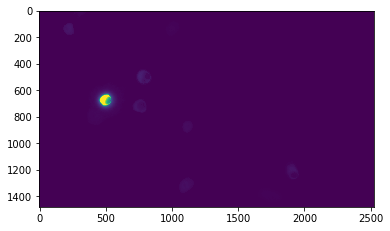

In [40]:
start_time = time.time()
#work
#path = f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline3"

#home
#path = f"C:{os.sep}Users{os.sep}William{os.sep}Documents{os.sep}Baseline"

#analysis
#path = f"D:{os.sep}William{os.sep}2018-12-04 Test data from 08-3"


dataframes = []
dfs = Parameters.iterate_through_files()


for index, items in enumerate(dfs):
    save_path = f'{data_path}{os.sep}{index}.pkl'
    items['Total'].to_pickle(save_path)


end_time = time.time()


print (f"Total Time is {end_time - start_time}")


                                           -1               0            \
                                           -1               0             
                                        Image Index    AniAvg  AniPixel   
0    Baseline_1_MMStack_1-Pos_000_003.ome.tif     0  0.045401 -0.252169   
1    Baseline_1_MMStack_1-Pos_000_003.ome.tif     1  0.048111 -0.247700   
2    Baseline_1_MMStack_1-Pos_000_003.ome.tif     2  0.090796 -0.172933   
3    Baseline_1_MMStack_1-Pos_000_003.ome.tif     3  0.070787 -0.206576   
4    Baseline_1_MMStack_1-Pos_000_003.ome.tif     4  0.084017 -0.184636   
5    Baseline_1_MMStack_1-Pos_000_003.ome.tif     5  0.071149 -0.208027   
6    Baseline_1_MMStack_1-Pos_000_003.ome.tif     6  0.077978 -0.195796   
7    Baseline_1_MMStack_1-Pos_000_003.ome.tif     7  0.061670 -0.242206   
8    Baseline_1_MMStack_1-Pos_000_003.ome.tif     8  0.068974 -0.210574   
9    Baseline_1_MMStack_1-Pos_000_003.ome.tif     9  0.084969 -0.183823   
10   Baseline_1_MMStack_1

[134 rows x 22 columns]


In [44]:
"""
Organize and output the dataframes to excel files


"""


sub_dataframe = dfs[0]["Total"]
columns = sub_dataframe.columns
sub_dataframe.loc[:, pd.IndexSlice[1,0,:]].mean()

#work
writer = pd.ExcelWriter(f"{data_path}{os.sep}test.xlsx", engine='xlsxwriter')

#home
#writer = pd.ExcelWriter("C:{os.sep}Users{os.sep}William{os.sep}Documents{os.sep}Baseline{os.sep}test.xlsx", engine='xlsxwriter')
#print (sub_dataframe)

sub_dataframe.to_excel(writer, "Raw_Data")
create_summary_columns(sub_dataframe).to_excel(writer, "Summary")

cell_cell_comparison = create_cell_comparisons(sub_dataframe, Parameters)
for key in cell_cell_comparison:
    cell_cell_comparison[key].to_excel(writer, key)

writer.save()



3
1



In [ ]:
"""


Cells beyond this point are not part of the main program...


"""

In [ ]:
class ImagingParameters():
    #Note: the input to __init__ may be replaced by just the config file path
    def __init__(self, data_path,
                 numerical_aperture=None, 
                 index_of_refraction=None, 
                 magnification = None, 
                 gFactor = None, 
                 channel_array = [1], 
                 image_type_array = ['Intensity'], 
                 channel_thresholds = 0, 
                 timepoints = 1, 
                 same_cells = False, 
                 max_filter_region = 5,
                 max_threshold =  600,
                 root_dir_same_treatment = True, 
                 suffix = "ome.tif", 
                 machine_learning_mode = False, 
                 debug_mode = False,
                 weights_path = "final.pt"):
        
        

        #    for key, value in **kwargs.iteritems():
        #        setattr(self, key, value)
        
        
        self.data_path = data_path
        self.numerical_aperture = numerical_aperture
        self.index_of_refraction = index_of_refraction
        self.magnification = magnification
        self.gFactor = gFactor
        self.channel_array = channel_array
        self.image_type_array = image_type_array
        self.max_filter_region = max_filter_region
        self.max_threhsold = max_threshold
        self.root_dir_same_treatment = root_dir_same_treatment
        self.suffix = suffix
        self.channel_thresholds = channel_thresholds
        self.machine_learning_mode = machine_learning_mode
        self.debug_mode = debug_mode
        
        
        self.weights_path = weights_path

In [ ]:

#create_cell_comparisons(sub_dataframe, Parameters)

In [ ]:
image_path = "D://Documents//Documents//0000 New Scope//Baseline3//Treat1//Baseline_1//Baseline_1_MMStack_1-Pos_000_003.ome.tif"
image = np.asarray(bioformats.load_image(image_path))
image = np.dstack([image, image*0.9, image*0.8])
print ("Max 1", np.amax(image))
image = ((image/np.amax(image))*255).astype('uint8')
print ("Max 2", np.amax(image))
#print (image)
image2 = cv2.rectangle(image, (200,0), (400, 1000), (255,0,0), 20)
plt.imshow(image2)

save_path = "D://Documents//Documents//0000 New Scope//Baseline3//debug//Treat1//Baseline_1//Baseline_1_MMStack_1-Pos_000_003.jpg"


imageio.imwrite(save_path, image2)

In [ ]:
#print (dfs[3])
for items in dfs:
    for keys in items:
        print (type(items[keys]), keys)
        #items[keys].pop("ROI")
        items[keys].to_csv("D:/Documents/Documents/0000 New Scope/Baseline3/test.csv")


"""final_dataframe = pd.DataFrame([])

for filenames in dfs[-1]:
    print (f"current filename is: {filenames}")
    df_interest = dfs[-1][filenames]
    print (type(df_interest))
    #print (df_interest)
    if len(final_dataframe)==0:
        print ("need a new dataframe")
        final_dataframe = df_interest
    else:
        print ("Appending")
        final_dataframe = final_dataframe.append(df_interest, ignore_index = True, sort = False)

print (final_dataframe)
"""

In [ ]:
array = np.ones((5,6))
array = np.pad(array, ((2,3), (0,1)), 'constant')
print (array)
print (array.shape)

In [ ]:
df = pd.DataFrame([], columns=["Image", "Index", "ROI"])
df.head()

imparameters = ImageParams(f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline{os.sep}Baseline_1",
                         "Baseline_1_MMStack_1-Pos_002_002.ome.tif", Parameters.channel_array, Parameters.image_type_array)

df2 = pd.DataFrame({"Image": [imparameters, 2], "ROI": [3,4]})
df3 = df.append(df2, sort=False)
df3.head()

print (df3.at[0, "Image"])

#for index, items in enumerate(df3["Image"]):
#    print (index, items)


In [ ]:
df2.dtypes

In [ ]:
np.array = []
array.append({"array": 1})
print ("array" in array[-1])
array.append([2,3])
print (array[-1][1])

In [ ]:
#Example full program::

In [ ]:
path = f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline_1"
dir_list = find_files(path)
iterate_through_files (dir_list)

In [ ]:
dff  = pd.DataFrame({("A", "B"): [1,2,3], ("A", "C"): [2,5,6], ("G"):[1,2,3]})
dff.at[2, ("A", "B")]= 100
for columns in dff.columns:
    print (columns[0])




In [ ]:
arr1 = np.array([1, 2, 3, 43, 6, 5])
arr2 = np.array([True, True, True, False, False, True])
arr4 = arr1[:4].copy()
arr3 = np.multiply (arr1, arr2)
print (arr3)
print (np.mean(arr3[arr3 !=0]))

print (arr4)
arr4[2] = 100
print (arr1)

In [ ]:
new_path = "D:/Documents/Documents/0000 New Scope/Baseline3/Treat1/Baseline_1/Baseline_1_MMStack_1-Pos_000_003.ome.tif"

import_image = np.asarray(bioformats.load_image(new_path, t=0, rescale = False)).astype('float')



In [ ]:
%%time
new_image = import_image.copy()

new_image [new_image <  10000] = np.nan

plt.imshow(new_image)
plt.colorbar()

In [ ]:
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()


fgmask = fgbg.apply(import_image)
cv2.imshow('frame',fgmask)
k = cv2.waitKey(30) & 0xff


cv2.destroyAllWindows()

In [ ]:
"""
BF Matcher

"""


bio_loc = f'{data_path}{os.sep}Baseline_1_MMStack_1-Pos_002_002.ome.tif'

bio_para_import = np.asarray(bioformats.load_image(bio_loc, 
                                          c = 0, z=0, t=1, rescale=False))

bio_perp_import = np.asarray(bioformats.load_image(bio_loc, 
                                          c = 0, z=0, t=2, rescale=False))

bio_para = skimage.img_as_ubyte(bio_para_import)
bio_perp = skimage.img_as_ubyte(bio_perp_import)

filtered_para = cv2.bilateralFilter(bio_para, 9, 75, 75)

print (type(bio_para[0,0]))
print(cv2.imread(bio_loc, 0).shape)
#bio_para = cv2.imread(bio_loc, 0)

#bio_perp = cv2.imread(bio_loc, 0)

print (type(bio_para[0,0]))

b = cv2.normalize(bio_para_import, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype = cv2.CV_8U)



print (bio_para.shape)
print (bio_para[:4,:4], bio_perp[:4, :4])
print (b[:4,:4])
print(type(b[0,0]))


orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(bio_para, None)
kp2, des2 = orb.detectAndCompute(bio_perp, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x: x.distance)


img3 = cv2.drawMatches(bio_para, kp1, bio_perp, kp2, matches[:10], None, flags = 2)
cv2.imshow("Matches", img3)
#plt.imshow(bio_para)
#plt.show()


#fig, axs = plt.subpolots(1, 1)
#axs = plt.hist(bio_para)

#plt.show()


cv2.imshow("Para", bio_para)
cv2.imshow("Bilateral", filtered_para)
cv2.imshow("Perp", bio_perp)
cv2.imshow("Difference", (bio_para - bio_perp)*100)
cv2.imshow("Normalizes", b)
cv2.waitKey(0)
cv2.destroyAllWindows()
#print (bioformats.get_omexml_metadata(path=f'{data_path}{os.sep}Baseline_1_MMStack_1-Pos_000_001.ome.tif'))


print (kp1, des1)


In [ ]:
plt.plot([1,2,3,4], [5,6,7,8], 'ro')
plt.axis([0,10,0,20])
plt.show()


bio_para_reshape = bio_para_import.reshape(-1, 1)
print (bio_para_reshape.shape)
bio_para_reshape2 = filtered_para.reshape(-1, 1)

x = 100+ 15*np.random.randn(10000)
#n, bins, patches = plt.hist(bio_para_reshape, 50)
n, bins, patches = plt.hist(bio_para_reshape2, 50)
print (max(bio_para_reshape2))


In [ ]:
"""def find_maxima (image, sigma = 9, h_value = None):
    
    if not h_value:
        h_value = max(image)/1000
              
    
    proc_image = cv2.GaussianBlur(img, (sigma, sigma), 0)
    
    local_maxima = extrema.h_maxima(proc_image, h_value)
    
    
    
    
    
    return (local_maxima)
    
    
    
    

local_maximums = find_maxima(bio_para_import, 1, 1)

fig, ax = plt.subplots(1, 3, figsize= (15,5))

ax[0].imshow(bio_para_import)

ax[1].imshow(local_maximums)

print (find_maxima(bio_para_import, 1, 1))

x = np.arange(bio_para_import.shape[1])
y = np.arange(bio_para_import.shape[0])



#x, y = np.meshgrid(x, y)
#ax[2].scatter(x, y, c=local_maximums[x,y])
#ax[2].show()

plt.imshow(find_maxima(bio_para_import, 1, 50))
"""

In [ ]:
from skimage.feature import peak_local_max
xy = peak_local_max(bio_para_import, min_distance=5,threshold_abs=1200)
plt.scatter(xy[:, 0], xy[:, 1])

In [ ]:
x = np.arange(10)
y = np.arange(16)
test_data = np.random.randint(low=0,high=65535, size=(10, 16))

#scatter plot the measurements with
# x - measurement index (0-9 in this case)
# y - byte value index (0-15 in this case) 
# c = test_data[x,y]

x, y = np.meshgrid(x,y)
plt.scatter(x,y,c=test_data[x,y])
plt.show()

In [ ]:



data_path = f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline_1"

print (os.listdir(data_path)[4])
print (f'{data_path}{os.sep}{os.listdir(data_path)[4]}')

img = cv2.imread(f'{data_path}{os.sep}{os.listdir(data_path)[4]}')*100
#cv2.imshow("image", (img[:,:,1]*1000))
#cv2.waitKey(0)
#cv2.destroyAllWindows()

cv2.circle(img, (2000,1000), 400, (255,255,255), -1)
points = np.array([[1,1], [33,4], [100,20], [50, 400]], np.int32)
cv2.polylines(img, [points], True, (0,255,255), 3)
cv2.putText(img, "Hello, world!", (0,100), cv2.FONT_HERSHEY_COMPLEX, 4, (255, 0, 0))

plt.imshow(img)
plt.show()

#img = np.ones((100,100,3))*1
#img[:,:,2] = np.arange(0, 100*100, 1).resize((100,100))
print (img[:,:,2])

gg = calculate_anisotropy(image = img, Parameters = Parameters)


print (gg.shape)
cv2.imwrite(f'{path}{os.sep}{os.listdir(path)[7]}2.tiff', gg)

#print (sum(sum(img-gg)))

#cv2.imshow("image", (img-gg)*1000)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [ ]:
"""Thresholding options
Works Well

from skimage.feature import peak_local_max
xy = peak_local_max(bio_para_import, min_distance=2,threshold_abs=1500)
plt.scatter(xy[:, 0], xy[:, 1])


Works Better:

import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt

fname = '/tmp/slice0000.png'
neighborhood_size = 40
threshold = 700


data = bio_para_import
#data = scipy.misc.imread(fname)

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    x.append(x_center)
    y_center = (dy.start + dy.stop - 1)/2    
    y.append(y_center)

plt.imshow(data)
#plt.savefig('/tmp/data.png', bbox_inches = 'tight')

plt.autoscale(False)
plt.plot(x,y, 'ro')
#plt.savefig('/tmp/result.png', bbox_inches = 'tight')

print (x, y)


"""

In [ ]:
#find all of the files in the current path
print(os.path.isdir(path))



"""for items in os.listdir(path):
    #print (items, "file:",  os.path.isfile(f"{path}/{items}"), "dir:",  os.path.isdir(f'{path}/{items}'))
    img = cv2.imread(f'{path}/{items}')
    cv2.imshow('image', img*100)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
"""

    
    
    
"""
Options for going up ap directory:

1) split path by "/" __file__.rsplit(os.sep, 2)  or print(path.rsplit('/')[-3])
2) iterate up twice os.path.dirname(os.path.dirname(path))



"""

In [ ]:
"""
Testing the find_files function
"""

path2 = "D:\\Documents\\Documents\\0000 New Scope\\2018-08-01 Nuclear Parameter Test"
#path2 = "D:/Documents/Documents/0000 New Scope/2018-08-01 Nuclear Parameter Test/N2(600-40)/Baseline/Baseline_1"
dir_list = {}
result = find_files(path2, dir_list)


for items in result:
    print (f'{items}, {result[items]}')

In [ ]:
data_path = f"D:{os.sep}Documents{os.sep}Documents{os.sep}0000 New Scope{os.sep}Baseline_1"
print (data_path)
directory_list = find_files(data_path, {})
print (directory_list)
iterate_through_files(directory_list)


bio_im = np.asarray(bioformats.load_image(f'{data_path}{os.sep}Baseline_1_MMStack_1-Pos_000_001.ome.tif', 
                                          c = 0, z=0, t=6, rescale=False))


In [ ]:
import matplotlib.image as mpimg

img=mpimg.imread(f'{data_path}{os.sep}Baseline_1_MMStack_1-Pos_000_000.ome.tif')
print (img.shape)

im = io.imread(f'{data_path}{os.sep}Baseline_1_MMStack_1-Pos_000_000.ome.tif')
print ((im.shape))

pilim = Image.open(f'{data_path}{os.sep}Baseline_1_MMStack_1-Pos_000_000.ome.tif')
print (pilim.n_frames)
print (pilim)
print (pilim.info)
print (pilim.load())
pilim.width